Agora, para cada atributo de modelagem, vamos reduzir o embedding com LDA usando tal atributo como rótulo, fazendo com que cada subespaço capture a similaridade dos produtos em relação a tal atributo.


Vamos olhar pros grupos de produto separadamente, já que não faria sentido comparar os atributos de grupos diferentes.

### FUNÇÕES

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Função que aplica LDA: recebe um df, as colunas desse df que contêm os embeddings e o número de componentes que se deseja obter
def apply_lda(df, colunas, n_components=2, lda=None, colum_target='COR_PREDOMINANTE'):
    """
    Aplica LDA nos embeddings para redução de dimensionalidade com base na coluna 'COR_PREDOMINANTE',
    ignorando valores nulos na coluna de target e retornando um novo DataFrame com as colunas desejadas.
    """
    df_filtered = df.copy()

    if not lda:
        # Inicializando o modelo LDA
        lda = LinearDiscriminantAnalysis(n_components=n_components)

        # Filtrando os dados para remover nulos na coluna 'COR_PREDOMINANTE'
        df_filtered = df_filtered.dropna(subset=[f'{colum_target}'])

        # Treinando o modelo e transformando os dados
        componentes = lda.fit_transform(df_filtered[colunas], df_filtered[f'{colum_target}'])

        # Criando um novo DataFrame com as colunas desejadas
        df_lda = df_filtered[['id_produto', f'{colum_target}']].copy()

    else:
        componentes = lda.transform(df_filtered[colunas])

        # Criando um novo DataFrame com as colunas desejadas
        df_lda = df_filtered[['id_produto']].copy()

    for i in range(n_components):
        df_lda[f'EMB_LDA_{i}'] = componentes[:, i]

    return df_lda, lda

In [22]:
# Função para plotar os componentes reduzidos com cores definidas por um dicionário
def plot_cores(df, cor_column='COR_PREDOMINANTE', reducer='LDA', color_dict=None, show=True):
    """
    Plota os componentes reduzidos colorindo os pontos com base em um dicionário de cores.
    """

    # Setando componente x e y conforme o reducer
    component_x, component_y = f'EMB_{reducer}_0', f'EMB_{reducer}_1'

    # Filtrando apenas as linhas que possuem valores válidos (sem NaN) nos componentes
    df_plot = df.dropna(subset=[component_x, component_y, cor_column])

    # Se o dicionário de cores não for fornecido, gerar um dicionário de cores padrão
    if color_dict is None:
        unique_colors = df_plot[cor_column].unique()
        color_dict = {color: plt.cm.tab20(i / len(unique_colors)) for i, color in enumerate(unique_colors)}

    # Removendo linhas com cores não mapeadas no dicionário de cores
    df_plot = df_plot[df_plot[cor_column].isin(color_dict.keys())]

    # Iterar por cada cor e plotar os pontos
    for cor, color_value in color_dict.items():
        subset = df_plot[df_plot[cor_column] == cor]
        
        # Adicionar borda preta se a cor for branca
        edge_color = 'black' if color_value == '#FFFFFF' else color_value

        plt.scatter(
            subset[component_x],
            subset[component_y],
            color=color_value,
            edgecolor=edge_color,  # Define a cor da borda
            linewidth=0.5 if color_value in ['#FFFFFF', '#F8F4E3'] else 0,  # Define a largura da borda para pontos brancos
            alpha=0.7,
            label=cor
        )

    # Botando a legenda deslocada para fora do gráfico
    plt.legend(title=f"{cor_column}", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(component_x)
    plt.ylabel(component_y)
    plt.title(f"Componentes {reducer} com cores de {cor_column}")
    if show:
        plt.show()

## VESTIDO

In [23]:
# Load data
df_vestido = pd.read_parquet('datasets/PILAR_MOD/df_vestido.parquet')

In [24]:
df_vestido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 550 to 765
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_path            216 non-null    object
 1   id_produto           216 non-null    object
 2   grupo_produto        216 non-null    object
 3   file_name            216 non-null    object
 4   original_file_path   216 non-null    object
 5   link                 216 non-null    object
 6   PRODUTOS             215 non-null    object
 7   CARACTERISTICAS      215 non-null    object
 8   ESTAMPA              215 non-null    object
 9   AMARRACAO_PESCOCO    215 non-null    object
 10  COR_PREDOMINANTE     215 non-null    object
 11  DECOTE_OU_GOLA       215 non-null    object
 12  AMARRACAO_CORPO      215 non-null    object
 13  ESTILO               215 non-null    object
 14  ZOOM_ESTAMPA         215 non-null    object
 15  COMPRIMENTO_MANGA    215 non-null    object
 16  FENDA_

In [301]:
df_vestido['ESTAMPA'].value_counts()

SEM_ESTAMPA            127
FLORAL                  21
GEOMETRICO              20
ANIMALPRINT_ONCA        13
LISTRADO_HORIZONTAL      7
MINIMALISTA              6
POA                      5
LISTRADO_VERTICAL        4
LISTRADO_OUTRO           2
ANIMALPRINT_COBRA        2
FOLHAGEM                 2
OUTRA                    1
TROPICAL                 1
TIE_DYE                  1
DEGRADE                  1
ESTAMPA_ETNICA           1
MARMORIZADA              1
Name: ESTAMPA, dtype: int64

In [25]:
# Puxando embeddings de vestidos

df_embs = pd.read_parquet('datasets/img_embeddings.parquet')

In [26]:
# Merge dos embeddings com os dados de vestidos
df_vestido = df_vestido.merge(df_embs, on='id_produto')

In [42]:
df_vestido

,file_path,id_produto,grupo_produto,file_name,original_file_path,link,PRODUTOS,CARACTERISTICAS,ESTAMPA,AMARRACAO_PESCOCO,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
0,animale_images_cropped/vestido/vestido_chemise...,07-16-0077-09657,vestido,vestido_chemise-de-georgette-midi-com-detalhe-...,animale_images/vestido_chemise-de-georgette-mi...,https://animaleproductsimages.s3.us-east-1.ama...,07-16-0077-09657,"{COMPRIMENTO_SAIA: LONGA, MODELAGEM_SAIA: SOLT...",GEOMETRICO,N/A,...,0.013368,-0.109843,0.242171,0.041957,-0.092089,-0.059380,0.330564,0.547463,-0.321597,-0.166808
1,animale_images_cropped/vestido/vestido_slip-dr...,07-20-6541-09621,vestido,vestido_slip-dress-de-georgette-com-detalhe-de...,animale_images/vestido_slip-dress-de-georgette...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6541-09621,"{COMPRIMENTO_SAIA: MIDI, MODELAGEM_SAIA: SOLTA...",ANIMALPRINT_ONCA,N/A,...,0.149645,-0.193680,0.026757,0.259797,-0.156597,-0.239967,0.051565,0.903962,-0.371020,0.478469
2,animale_images_cropped/vestido/vestido_slipdre...,07-20-6630-09258,vestido,vestido_slipdress-de-crepe-verde-folha_verde-f...,animale_images/vestido_slipdress-de-crepe-verd...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6630-09258,{COMPRIMENTO_SAIA: MIDI;MODELAGEM_SAIA: RETA;C...,SEM_ESTAMPA,N/A,...,0.155217,-0.286216,-0.005060,0.100207,-0.201234,0.045059,0.057862,1.141839,-0.155673,0.417849
3,animale_images_cropped/vestido/vestido_slipdre...,07-20-6705-03344,vestido,vestido_slipdress-de-crepe-verde-simply_verde-...,animale_images/vestido_slipdress-de-crepe-verd...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6705-03344,"{COMPRIMENTO_SAIA: MIDI, MODELAGEM_SAIA: JUSTA...",SEM_ESTAMPA,N/A,...,0.111911,-0.301749,-0.089514,0.218864,-0.301931,-0.002409,-0.067367,1.056152,-0.216578,0.417800
4,animale_images_cropped/vestido/vestido_vestido...,07-20-6347-09538,vestido,vestido_vestido-alcinha-cobra_est-cobra-biscio...,animale_images/vestido_vestido-alcinha-cobra_e...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6347-09538,"{COMPRIMENTO_SAIA: CURTA, MODELAGEM_SAIA: JUST...",ANIMALPRINT_COBRA,N/A,...,0.217348,-0.278970,-0.012059,0.396979,0.082821,-0.351988,0.042435,0.157919,-0.033546,0.299118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,animale_images_cropped/vestido/vestido_vestido...,07-20-6778-0005,vestido,vestido_vestido-tricot-transparencia_preto_07-...,animale_images/vestido_vestido-tricot-transpar...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6778-0005,"{COMPRIMENTO_SAIA: LONGA, MODELAGEM_SAIA: SOLT...",SEM_ESTAMPA,N/A,...,-0.169518,-0.099625,0.346413,-0.277054,0.040731,-0.580248,-0.106754,0.754394,-0.125312,0.119866
212,animale_images_cropped/vestido/vestido_vestido...,07-20-6402-09248,vestido,vestido_vestido-tube_laranja-aura_07-20-6402-0...,animale_images/vestido_vestido-tube_laranja-au...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6402-09248,{COMPRIMENTO_SAIA: LONGA;MODELAGEM_SAIA: JUSTA...,SEM_ESTAMPA,N/A,...,-0.130489,-0.199756,0.095518,0.122175,-0.062147,-0.073805,0.037836,0.989817,-0.157222,0.231829
213,animale_images_cropped/vestido/vestido_vestido...,07-20-6401-0005,vestido,vestido_vestido-tube_preto_07-20-6401-0005.jpg,animale_images/vestido_vestido-tube_preto_07-2...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6401-0005,{COMPRIMENTO_SAIA: LONGA;MODELAGEM_SAIA: JUSTA...,SEM_ESTAMPA,N/A,...,-0.256586,-0.288520,0.117256,0.030498,-0.306072,-0.199355,0.063874,0.299538,-0.106902,-0.006913
214,animale_images_cropped/vestido/vestido_vestido...,07-20-6659-09538,vestido,vestido_vestido-tule-babados-lili-est-leopardo...,animale_images/vestido_vestido-tule-babados-li...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6659-09538,"{COMPRIMENTO_SAIA: LONGA, MODELAGEM_SAIA: SOLT...",ANIMALPRINT_ONCA,N/A,...,0.069929,-0.363056,0.518750,0.049510,-0.099344,-0.377

### COMPRIMENTO_SAIA

In [91]:
df_vestido['COMPRIMENTO_SAIA'].value_counts()

MIDI     94
LONGA    76
CURTA    45
Name: COMPRIMENTO_SAIA, dtype: int64

In [92]:
df_vestido

,file_path,id_produto,grupo_produto,file_name,original_file_path,link,PRODUTOS,CARACTERISTICAS,ESTAMPA,AMARRACAO_PESCOCO,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
0,animale_images_cropped/vestido/vestido_chemise...,07-16-0077-09657,vestido,vestido_chemise-de-georgette-midi-com-detalhe-...,animale_images/vestido_chemise-de-georgette-mi...,https://animaleproductsimages.s3.us-east-1.ama...,07-16-0077-09657,"{COMPRIMENTO_SAIA: LONGA, MODELAGEM_SAIA: SOLT...",GEOMETRICO,N/A,...,0.013368,-0.109843,0.242171,0.041957,-0.092089,-0.059380,0.330564,0.547463,-0.321597,-0.166808
1,animale_images_cropped/vestido/vestido_slip-dr...,07-20-6541-09621,vestido,vestido_slip-dress-de-georgette-com-detalhe-de...,animale_images/vestido_slip-dress-de-georgette...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6541-09621,"{COMPRIMENTO_SAIA: MIDI, MODELAGEM_SAIA: SOLTA...",ANIMALPRINT_ONCA,N/A,...,0.149645,-0.193680,0.026757,0.259797,-0.156597,-0.239967,0.051565,0.903962,-0.371020,0.478469
2,animale_images_cropped/vestido/vestido_slipdre...,07-20-6630-09258,vestido,vestido_slipdress-de-crepe-verde-folha_verde-f...,animale_images/vestido_slipdress-de-crepe-verd...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6630-09258,{COMPRIMENTO_SAIA: MIDI;MODELAGEM_SAIA: RETA;C...,SEM_ESTAMPA,N/A,...,0.155217,-0.286216,-0.005060,0.100207,-0.201234,0.045059,0.057862,1.141839,-0.155673,0.417849
3,animale_images_cropped/vestido/vestido_slipdre...,07-20-6705-03344,vestido,vestido_slipdress-de-crepe-verde-simply_verde-...,animale_images/vestido_slipdress-de-crepe-verd...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6705-03344,"{COMPRIMENTO_SAIA: MIDI, MODELAGEM_SAIA: JUSTA...",SEM_ESTAMPA,N/A,...,0.111911,-0.301749,-0.089514,0.218864,-0.301931,-0.002409,-0.067367,1.056152,-0.216578,0.417800
4,animale_images_cropped/vestido/vestido_vestido...,07-20-6347-09538,vestido,vestido_vestido-alcinha-cobra_est-cobra-biscio...,animale_images/vestido_vestido-alcinha-cobra_e...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6347-09538,"{COMPRIMENTO_SAIA: CURTA, MODELAGEM_SAIA: JUST...",ANIMALPRINT_COBRA,N/A,...,0.217348,-0.278970,-0.012059,0.396979,0.082821,-0.351988,0.042435,0.157919,-0.033546,0.299118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,animale_images_cropped/vestido/vestido_vestido...,07-20-6778-0005,vestido,vestido_vestido-tricot-transparencia_preto_07-...,animale_images/vestido_vestido-tricot-transpar...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6778-0005,"{COMPRIMENTO_SAIA: LONGA, MODELAGEM_SAIA: SOLT...",SEM_ESTAMPA,N/A,...,-0.169518,-0.099625,0.346413,-0.277054,0.040731,-0.580248,-0.106754,0.754394,-0.125312,0.119866
212,animale_images_cropped/vestido/vestido_vestido...,07-20-6402-09248,vestido,vestido_vestido-tube_laranja-aura_07-20-6402-0...,animale_images/vestido_vestido-tube_laranja-au...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6402-09248,{COMPRIMENTO_SAIA: LONGA;MODELAGEM_SAIA: JUSTA...,SEM_ESTAMPA,N/A,...,-0.130489,-0.199756,0.095518,0.122175,-0.062147,-0.073805,0.037836,0.989817,-0.157222,0.231829
213,animale_images_cropped/vestido/vestido_vestido...,07-20-6401-0005,vestido,vestido_vestido-tube_preto_07-20-6401-0005.jpg,animale_images/vestido_vestido-tube_preto_07-2...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6401-0005,{COMPRIMENTO_SAIA: LONGA;MODELAGEM_SAIA: JUSTA...,SEM_ESTAMPA,N/A,...,-0.256586,-0.288520,0.117256,0.030498,-0.306072,-0.199355,0.063874,0.299538,-0.106902,-0.006913
214,animale_images_cropped/vestido/vestido_vestido...,07-20-6659-09538,vestido,vestido_vestido-tule-babados-lili-est-leopardo...,animale_images/vestido_vestido-tule-babados-li...,https://animaleproductsimages.s3.us-east-1.ama...,07-20-6659-09538,"{COMPRIMENTO_SAIA: LONGA, MODELAGEM_SAIA: SOLT...",ANIMALPRINT_ONCA,N/A,...,0.069929,-0.363056,0.518750,0.049510,-0.099344,-0.377

In [93]:
emb_columns = [col for col in df_vestido.columns if col.startswith('emb_img_')]

In [94]:
# Aplicando LDA 
df_lda_comprimento_saia, lda_comprimento_saia = apply_lda(df_vestido, emb_columns, n_components=2, colum_target='COMPRIMENTO_SAIA')

In [95]:
df_lda_comprimento_saia

,id_produto,COMPRIMENTO_SAIA,EMB_LDA_0,EMB_LDA_1
0,07-16-0077-09657,LONGA,2.361665,-4.382169
1,07-20-6541-09621,MIDI,0.505272,-0.296457
2,07-20-6630-09258,MIDI,4.077519,-0.598631
3,07-20-6705-03344,MIDI,1.223251,2.099827
4,07-20-6347-09538,CURTA,-5.381951,-0.527565
...,...,...,...,...
211,07-20-6778-0005,LONGA,3.206413,-1.818832
212,07-20-6402-09248,LONGA,2.026002,-1.672297
213,07-20-6401-0005,LONGA,2.577563,-2.131843
214,07-20-6659-09538,LONGA,1.878229,-1.300685


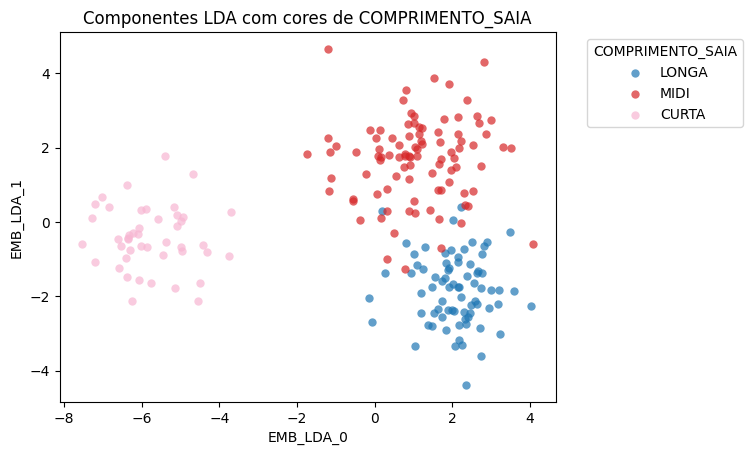

In [96]:
# Plotando os componentes reduzidos
plot_cores(df_lda_comprimento_saia, cor_column='COMPRIMENTO_SAIA', reducer='LDA')

In [97]:
from umap.umap_ import UMAP

def calcular_centroides(df, colunas, target_column):
    """
    Calcula os centróides para cada categoria em 'target_column' com base nas colunas fornecidas.
    Retorna um DataFrame com os centróides e a categoria correspondente.
    """
    # 1. Calcular os centróides para cada {target_column}
    df_centroides = df.drop(columns={'id_produto'}).groupby(f'{target_column}').mean().reset_index()

    # 2. Adicionar a coluna 'id_produto' aos centróides
    df_centroides['id_produto'] = df_centroides[f'{target_column}'].apply(lambda x: f'CLUSTER_{x}')

    # 3. Adicionar uma coluna para identificar os centróides
    df_centroides['is_centroid'] = True
    
    df['is_centroid'] = False  # Para os dados originais

    # 4. Concatenar os dados originais com os centróides
    df_combined = pd.concat([df, df_centroides], ignore_index=True)

    return df_combined

In [98]:
colunas_lda = [col for col in df_lda_comprimento_saia.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_comprimento_saia
df_combined_comprimento_saia = calcular_centroides(df_lda_comprimento_saia, colunas_lda, 'COMPRIMENTO_SAIA')

In [99]:
df_combined_comprimento_saia

,id_produto,COMPRIMENTO_SAIA,EMB_LDA_0,EMB_LDA_1,is_centroid
0,07-16-0077-09657,LONGA,2.361665,-4.382169,False
1,07-20-6541-09621,MIDI,0.505272,-0.296457,False
2,07-20-6630-09258,MIDI,4.077519,-0.598631,False
3,07-20-6705-03344,MIDI,1.223251,2.099827,False
4,07-20-6347-09538,CURTA,-5.381951,-0.527565,False
...,...,...,...,...,...
213,07-20-6659-09538,LONGA,1.878229,-1.300685,False
214,07-20-5723-0005,CURTA,-5.095122,-0.121544,False
215,CLUSTER_CURTA,CURTA,-5.771308,-0.428662,True
216,CLUSTER_LONGA,LONGA,2.057616,-1.819608,True


In [142]:
import plotly.graph_objects as go

def plot_clusters_with_centroids(
    df_combined, 
    target_column, 
    embedding_columns, 
    color_dict=None, 
    title="Visualização de Clusters com Centróides", 
    apply_umap=False, 
    umap_params=None
):
    """
    Cria um gráfico de dispersão interativo com os clusters e seus centróides.
    
    Parâmetros:
    - df_combined: DataFrame contendo os dados originais e os centróides.
    - target_column: Nome da coluna que contém as categorias dos clusters.
    - embedding_columns: Lista com os nomes das colunas de embeddings.
    - color_dict: Dicionário com as cores específicas para cada categoria. Default: cores automáticas.
    - title: Título do gráfico. Default: "Visualização de Clusters com Centróides".
    - apply_umap: Booleano indicando se UMAP deve ser aplicado. Default: False.
    - umap_params: Dicionário com parâmetros para o UMAP. Default: None.
    
    Retorna:
    - Objeto Figure do Plotly.
    """
    # Aplicar UMAP se solicitado
    if apply_umap:
        umap_params = umap_params or {'n_neighbors': 15, 'n_components': 2, 'random_state': 42}
        umap = UMAP(**umap_params)
        
        embeddings = df_combined[embedding_columns].values
        umap_embeddings = umap.fit_transform(embeddings)

        # Adicionar os embeddings reduzidos ao DataFrame
        df_combined['UMAP_0'] = umap_embeddings[:, 0]
        df_combined['UMAP_1'] = umap_embeddings[:, 1]

        # Ajustar as colunas para o gráfico
        embedding_columns = ['UMAP_0', 'UMAP_1']

    # Separar dados originais e centróides
    df_original = df_combined[df_combined['is_centroid'] == False].copy()
    df_original['Tipo'] = 'Original'

    df_centroids = df_combined[df_combined['is_centroid'] == True].copy()
    df_centroids['Tipo'] = 'Centróide'

    # Gerar um dicionário de cores se não fornecido
    if color_dict is None:
        categorias = df_original[target_column].unique()
        # Setando paleta de cores do tableau
        color_palette = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            '#ff9896', '#aec7e8', '#ffbb78', '#98df8a'
        ]
        color_dict = {categoria: color_palette[i % len(color_palette)] for i, categoria in enumerate(categorias)}

    # Criação do gráfico com Plotly
    fig = go.Figure()

    # Adicionar os pontos dos dados originais por categoria
    for categoria, cor in color_dict.items():
        subset = df_original[df_original[target_column] == categoria]
        fig.add_trace(go.Scatter(
            x=subset[embedding_columns[0]],
            y=subset[embedding_columns[1]],
            mode='markers',
            marker=dict(color=cor, size=8, line=dict(width=1, color='black')),
            name=f'{categoria}',
            hoverinfo='text',
            text=subset['id_produto']
        ))

    # Adicionar os centróides com cor fixa
    fig.add_trace(go.Scatter(
        x=df_centroids[embedding_columns[0]],
        y=df_centroids[embedding_columns[1]],
        mode='markers',
        marker=dict(color='red', symbol='x', size=10, line=dict(width=0.5)),
        name='Centróides',
        hoverinfo='text',
        text=df_centroids['id_produto']
    ))

    # Configuração do layout
    fig.update_layout(
        title=title,
        xaxis_title=f'{embedding_columns[0]}',
        yaxis_title=f'{embedding_columns[1]}',
        legend_title='Legenda',
        template='plotly_white',
        hovermode='closest'
    )

    # Mostrar o gráfico
    return fig


In [146]:
# Lista das colunas de embeddings de alta dimensionalidade
embedding_columns = [col for col in df_lda_comprimento_saia.columns if col.startswith('EMB_LDA')]

# Gerar o gráfico com UMAP
fig = plot_clusters_with_centroids(
    df_combined=df_combined_comprimento_saia,
    target_column='COMPRIMENTO_SAIA',
    embedding_columns=embedding_columns,
    color_dict=None,  # Opcional, pode ser None
    title="Visualização de Clusters com Centróides (LDA + UMAP)",
    apply_umap=False,  # Aplicar UMAP
)

# Mostrar o gráfico
fig.show()


#### Testando busca

In [215]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [255]:
import os

# Gerando os embeddings das imagens teste
pasta = "teste_images_mod"

# Criando lista com as image_paths da pasta
image_paths = [os.path.join(pasta, path).replace('\\','/') for path in os.listdir(pasta)]

# Criando um df_color com os nomes das imagens
df_teste = pd.DataFrame(image_paths, columns=["image_path"])

In [256]:
# Now we load and encode the images
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

file_names = df_teste['image_path'].values
images = [load_image(img) for img in file_names]
img_embeddings = img_model.encode(images)

img_embeddings

array([[ 0.01226628, -0.26083592, -0.07906748, ...,  0.7377187 ,
         0.15246785,  0.25277764],
       [ 0.22061878, -0.2678994 , -0.23263933, ...,  0.4289417 ,
        -0.22583073,  0.576701  ],
       [ 0.02449791, -0.48237398, -0.18431625, ...,  0.5764401 ,
         0.27470863,  0.15271458],
       [-0.13230473, -0.10835531, -0.16337915, ...,  0.4297725 ,
         0.07630856,  0.20189278],
       [ 0.21666357, -0.20436409,  0.08899249, ..., -0.02351616,
        -0.04712257,  0.6310549 ],
       [-0.4141708 ,  0.03018391, -0.10096473, ...,  0.43763497,
         0.22761305,  0.18242338]], dtype=float32)

In [280]:
# Adicionando embeddings em df_teste
emb_dict = {}

for i, emb in enumerate(img_embeddings):
    emb_id = df_teste.iloc[i]["image_path"]
    emb_dict[emb_id] = emb

df_teste_embs = pd.DataFrame(emb_dict).T

# Renomeando as colunas de embedding para emb_i
df_teste_embs.columns = [f'emb_img_{i}' for i in range(df_teste_embs.shape[1])]

In [281]:
df_teste_embs

,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,emb_img_8,emb_img_9,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
teste_images_mod/mini_vestido.png,0.012266,-0.260836,-0.079067,-0.069574,-0.564830,0.406523,-0.204432,-0.160638,0.644424,-0.110331,...,-0.157533,-0.249203,0.003009,-0.134244,0.140638,0.134554,-0.033643,0.737719,0.152468,0.252778
teste_images_mod/mini_vestido_cortado.png,0.220619,-0.267899,-0.232639,0.199145,-0.531839,0.348402,-0.455290,0.299250,0.825540,0.261111,...,-0.319483,-0.207908,-0.026798,0.202732,0.125557,0.019907,-0.184626,0.428942,-0.225831,0.576701
teste_images_mod/vestido_curto.png,0.024498,-0.482374,-0.184316,0.410925,-0.383706,0.468353,-0.537866,-0.530053,0.513004,0.128928,...,-0.086996,-0.366613,0.126021,-0.009878,-0.267037,0.402678,0.058856,0.576440,0.274709,0.152715
teste_images_mod/vestido_longo.png,-0.132305,-0.108355,-0.163379,0.296344,-0.408613,0.205606,0.030469,0.068894,0.307375,0.021962,...,0.178809,-0.265537,0.777755,-0.206991,0.043326,0.393958,0.226706,0.429772,0.076309,0.201893
teste_images_mod/vestido_midi.png,0.216664,-0.204364,0.088992,0.079027,-0.352131,0.070731,-0.034245,0.249059,0.283809,-0.411164,...,0.176434,-0.064351,0.619432,0.119277,-0.154959,0.269100,-0.035039,-0.023516,-0.047123,0.631055
teste_images_mod/vestido_mini_2.png,-0.414171,0.030184,-0.100965,-0.025997,-0.503955,0.248266,0.030760,0.191823,0.895498,0.007747,...,0.180666,-0.047660,0.039923,-0.381571,0.163323,0.321632,0.036774,0.437635,0.227613,0.182423


In [282]:
lda_comprimento_saia

LinearDiscriminantAnalysis(n_components=2)

In [283]:
colunas_embs = [col for col in df_teste_embs.columns if 'emb_img' in col]

In [286]:
df_teste_embs.reset_index(inplace=True)

# Renomear index para id_produto
df_teste_embs.rename(columns={'index': 'id_produto'}, inplace=True)

In [287]:
# Aplicando mesmo LDA usado no treinamento
img_embs_teste_lda, lda_comprimento_saia = apply_lda(df_teste_embs, colunas_embs, 2, lda=lda_comprimento_saia)

In [263]:
img_embs_teste_lda

,id_produto,EMB_LDA_0,EMB_LDA_1
0,teste_images_mod/mini_vestido.png,2.076149,-4.352036
1,teste_images_mod/mini_vestido_cortado.png,-6.008185,3.473059
2,teste_images_mod/vestido_curto.png,4.835263,1.873818
3,teste_images_mod/vestido_longo.png,0.801344,-4.973440
4,teste_images_mod/vestido_midi.png,0.432759,-1.789621
5,teste_images_mod/vestido_mini_2.png,-4.860133,-4.786244


In [288]:
colunas_lda = [col for col in df_lda_comprimento_saia.columns if col.startswith('EMB_LDA')]

In [269]:
# max width
pd.set_option('display.max_colwidth', None)

In [272]:
df_vestido.loc[df_vestido['id_produto'] == '07-20-6399-0030']

,file_path,id_produto,grupo_produto,file_name,original_file_path,link,PRODUTOS,CARACTERISTICAS,ESTAMPA,AMARRACAO_PESCOCO,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
173,animale_images_cropped/vestido/vestido_vestido-midi-com-detalhe-no-busto-bege-g_bege_07-20-6399-0030.jpg,07-20-6399-0030,vestido,vestido_vestido-midi-com-detalhe-no-busto-bege-g_bege_07-20-6399-0030.jpg,animale_images/vestido_vestido-midi-com-detalhe-no-busto-bege-g_bege_07-20-6399-0030.jpg,https://animaleproductsimages.s3.us-east-1.amazonaws.com/foto_original/vestido_vestido-midi-com-detalhe-no-busto-bege-g_bege_07-20-6399-0030.jpg,07-20-6399-0030,{COMPRIMENTO_SAIA: MIDI;MODELAGEM_SAIA: JUSTA;COMPRIMENTO_MANGA: ALCA;FENDA_PERNA: SIM;DECOTE_OU_GOLA: CORACAO;AMARRACAO_CORPO: N/A;AMARRACAO_PESCOCO: N/A;COR_PREDOMINANTE: BEGE;LOCALIZACAO_ESTAMPA: N/A;ZOOM_ESTAMPA: N/A;ESTAMPA: SEM_ESTAMPA;ESTILO: FESTIVO;},SEM_ESTAMPA,N/A,...,-0.143324,-0.414413,-0.037308,0.027627,-0.157123,-0.011404,-0.053807,0.8639,-0.155126,0.47446


In [292]:
df_teste_embs

,id_produto,file_path,emb_img_0,emb_img_1,emb_img_2,emb_img_3,emb_img_4,emb_img_5,emb_img_6,emb_img_7,...,emb_img_502,emb_img_503,emb_img_504,emb_img_505,emb_img_506,emb_img_507,emb_img_508,emb_img_509,emb_img_510,emb_img_511
0,0,teste_images_mod/mini_vestido.png,0.012266,-0.260836,-0.079067,-0.069574,-0.564830,0.406523,-0.204432,-0.160638,...,-0.157533,-0.249203,0.003009,-0.134244,0.140638,0.134554,-0.033643,0.737719,0.152468,0.252778
1,1,teste_images_mod/mini_vestido_cortado.png,0.220619,-0.267899,-0.232639,0.199145,-0.531839,0.348402,-0.455290,0.299250,...,-0.319483,-0.207908,-0.026798,0.202732,0.125557,0.019907,-0.184626,0.428942,-0.225831,0.576701
2,2,teste_images_mod/vestido_curto.png,0.024498,-0.482374,-0.184316,0.410925,-0.383706,0.468353,-0.537866,-0.530053,...,-0.086996,-0.366613,0.126021,-0.009878,-0.267037,0.402678,0.058856,0.576440,0.274709,0.152715
3,3,teste_images_mod/vestido_longo.png,-0.132305,-0.108355,-0.163379,0.296344,-0.408613,0.205606,0.030469,0.068894,...,0.178809,-0.265537,0.777755,-0.206991,0.043326,0.393958,0.226706,0.429772,0.076309,0.201893
4,4,teste_images_mod/vestido_midi.png,0.216664,-0.204364,0.088992,0.079027,-0.352131,0.070731,-0.034245,0.249059,...,0.176434,-0.064351,0.619432,0.119277,-0.154959,0.269100,-0.035039,-0.023516,-0.047123,0.631055
5,5,teste_images_mod/vestido_mini_2.png,-0.414171,0.030184,-0.100965,-0.025997,-0.503955,0.248266,0.030760,0.191823,...,0.180666,-0.047660,0.039923,-0.381571,0.163323,0.321632,0.036774,0.437635,0.227613,0.182423


Dimensões de euclidean_dist: torch.Size([6, 215])
Imagem de Teste: teste_images_mod/mini_vestido.png


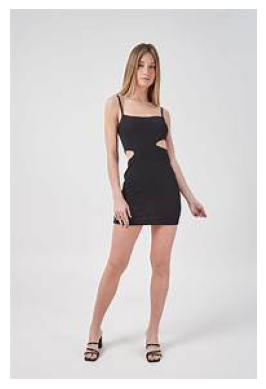

Similaridade (ID do produto): 07-16-0077-09657 - Distância Euclidiana: 0.29


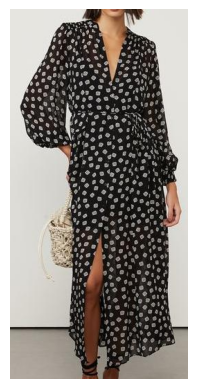

Similaridade (ID do produto): 07-20-6571-09244 - Distância Euclidiana: 1.00


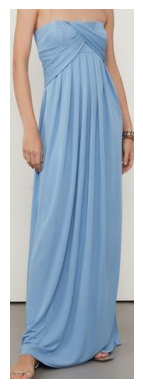

Similaridade (ID do produto): 07-20-6832-09792 - Distância Euclidiana: 1.01


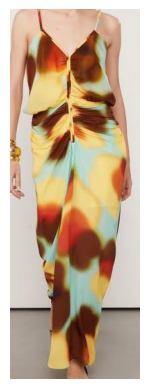


--------------------------------------------------

Imagem de Teste: teste_images_mod/mini_vestido_cortado.png


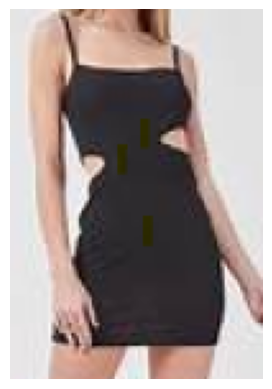

Similaridade (ID do produto): 07-20-6935-09276 - Distância Euclidiana: 1.81


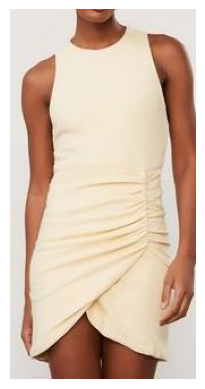

Similaridade (ID do produto): 07-20-6675-0005 - Distância Euclidiana: 2.50


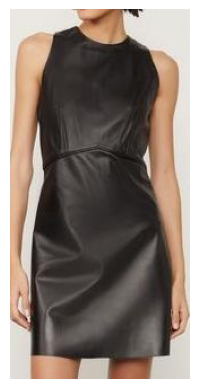

Similaridade (ID do produto): 07-20-6628-09050 - Distância Euclidiana: 2.54


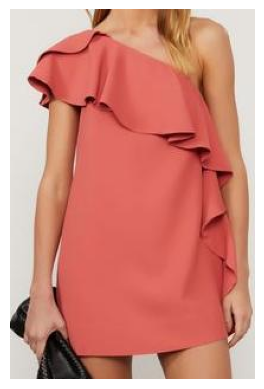


--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_curto.png


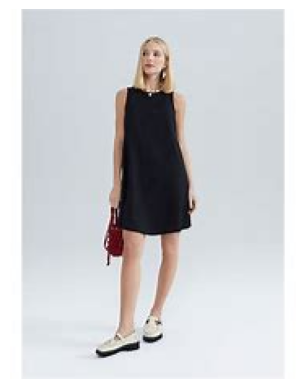

Similaridade (ID do produto): 07-20-6342-09050 - Distância Euclidiana: 1.34


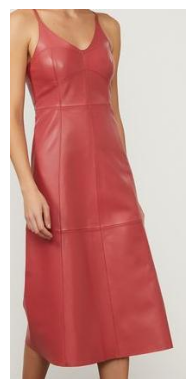

Similaridade (ID do produto): 07-20-6417-03023 - Distância Euclidiana: 1.53


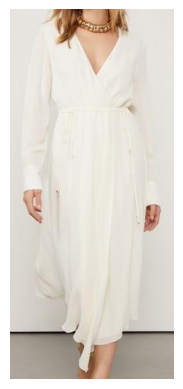

Similaridade (ID do produto): 07-20-6355-09253 - Distância Euclidiana: 2.02


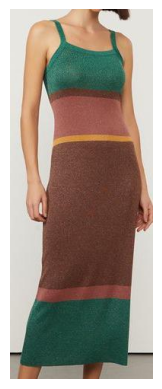


--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_longo.png


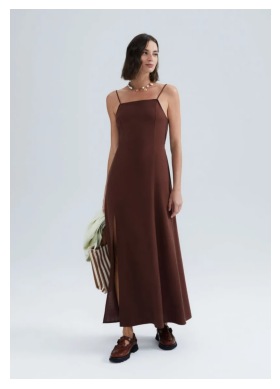

Similaridade (ID do produto): 07-20-6715-0005 - Distância Euclidiana: 1.66


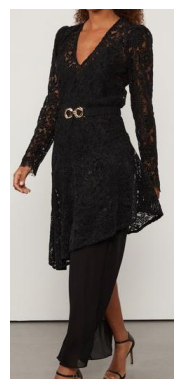

Similaridade (ID do produto): 07-16-0077-09657 - Distância Euclidiana: 1.67


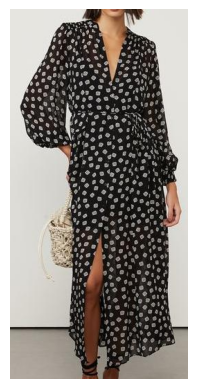

Similaridade (ID do produto): 07-20-6832-09792 - Distância Euclidiana: 2.06


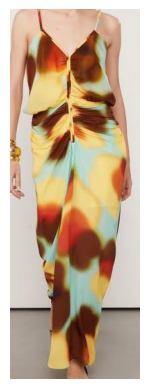


--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_midi.png


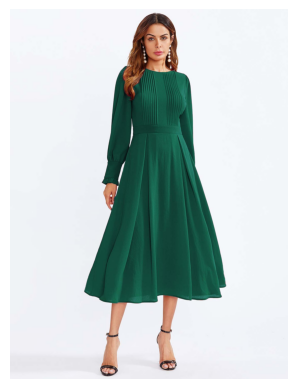

Similaridade (ID do produto): 07-20-6549-0003 - Distância Euclidiana: 0.43


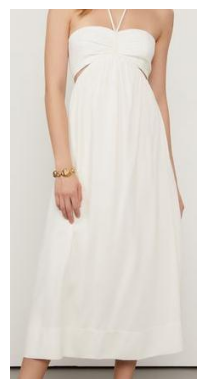

Similaridade (ID do produto): 07-20-6857-09845 - Distância Euclidiana: 0.63


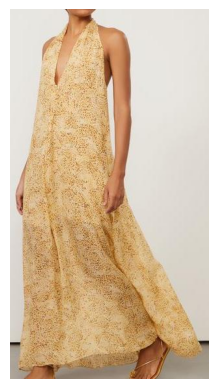

Similaridade (ID do produto): 07-20-6221-0005 - Distância Euclidiana: 0.63


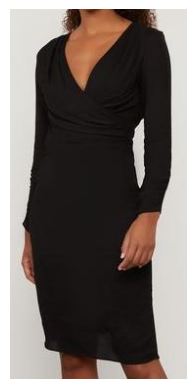


--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_mini_2.png


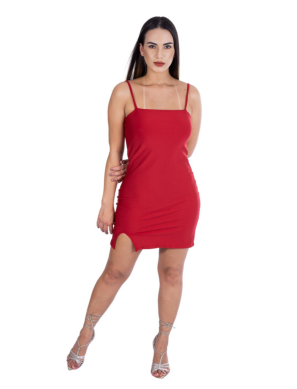

Similaridade (ID do produto): 07-20-6700-04501 - Distância Euclidiana: 2.68


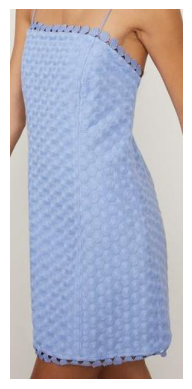

Similaridade (ID do produto): 07-99-0034-09601 - Distância Euclidiana: 3.00


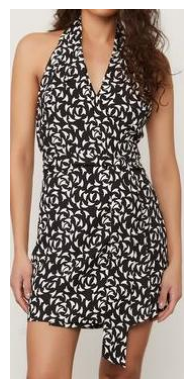

Similaridade (ID do produto): 07-20-6472-09249 - Distância Euclidiana: 3.03


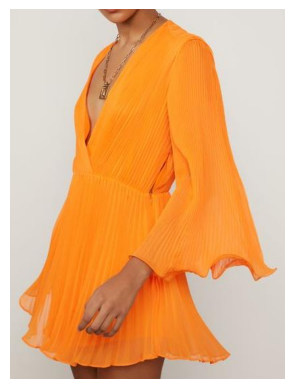


--------------------------------------------------



In [297]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # Para carregar imagens

def plot_image(image_path):
    """
    Função para plotar uma imagem a partir de um caminho.
    """
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Garantir que os dados estão no formato tensor
img_embs_teste = torch.tensor(img_embs_teste_lda[colunas_lda].values)
img_embs_completo = torch.tensor(df_lda_comprimento_saia[colunas_lda].values)

# Calcular distância euclidiana
euclidean_dist = torch.cdist(img_embs_teste, img_embs_completo, p=2)

# Verificar as dimensões
print(f"Dimensões de euclidean_dist: {euclidean_dist.shape}")  # Deve ser (num_test, num_dataset)

# Para cada imagem teste, retornando as 3 imagens mais similares
for i, distances in enumerate(euclidean_dist):
    print(f"Imagem de Teste: {df_teste.iloc[i]['image_path']}")
    plot_image(df_teste.iloc[i]['image_path'])
    
    # Garantir que distances esteja no CPU antes de converter para NumPy
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()
    
    # Obter os 3 índices com menores distâncias (mais similares)
    top_3_indices = distances.argsort()[:3]
    
    for idx in top_3_indices:
        similar_id = df_lda_comprimento_saia.iloc[idx]['id_produto']
        similar_score = distances[idx]
        print(f"Similaridade (ID do produto): {similar_id} - Distância Euclidiana: {similar_score:.2f}")
        plot_image(df_vestido.loc[df_vestido['id_produto'] == similar_id]['file_path'].values[0])
    
    print("\n" + "-"*50 + "\n")


Dimensões de euclidean_dist: torch.Size([6, 3])
Imagem de Teste: teste_images_mod/mini_vestido.png


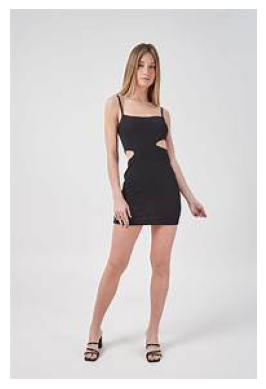

Centróide mais próximo: CLUSTER_LONGA - Distância Euclidiana: 2.53

--------------------------------------------------

Imagem de Teste: teste_images_mod/mini_vestido_cortado.png


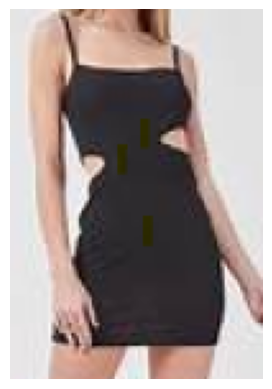

Centróide mais próximo: CLUSTER_CURTA - Distância Euclidiana: 3.91

--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_curto.png


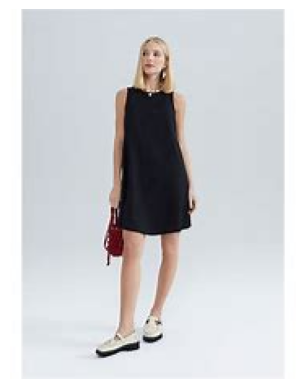

Centróide mais próximo: CLUSTER_MIDI - Distância Euclidiana: 3.74

--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_longo.png


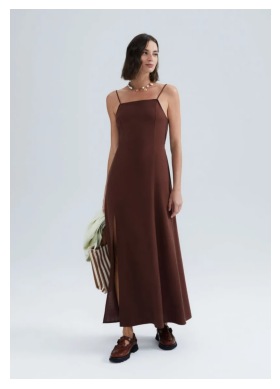

Centróide mais próximo: CLUSTER_LONGA - Distância Euclidiana: 3.39

--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_midi.png


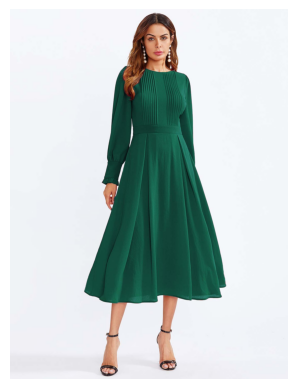

Centróide mais próximo: CLUSTER_LONGA - Distância Euclidiana: 1.63

--------------------------------------------------

Imagem de Teste: teste_images_mod/vestido_mini_2.png


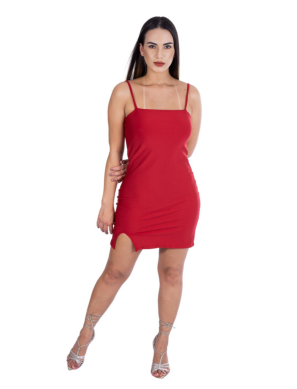

Centróide mais próximo: CLUSTER_CURTA - Distância Euclidiana: 4.45

--------------------------------------------------



In [300]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Função para exibir imagens
def plot_image(image_path):
    """
    Função para plotar uma imagem a partir de um caminho.
    """
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Certifique-se de converter os dados para tensores PyTorch
img_embs_teste = torch.tensor(img_embs_teste_lda[colunas_lda].values)
img_embs_centroides = torch.tensor(
    df_combined_comprimento_saia[df_combined_comprimento_saia['is_centroid'] == True][colunas_lda].values
)

# Calcular distância euclidiana
euclidean_dist = torch.cdist(img_embs_teste, img_embs_centroides, p=2)

# Verificar as dimensões
print(f"Dimensões de euclidean_dist: {euclidean_dist.shape}")  # Deve ser (num_test, num_centroids)

# Para cada imagem de teste, calcular a distância com cada centróide
for i, distances in enumerate(euclidean_dist):
    print(f"Imagem de Teste: {df_teste.iloc[i]['image_path']}")
    plot_image(df_teste.iloc[i]['image_path'])  # Exibir a imagem de teste
    
    # Garantir que distances esteja no CPU antes de converter para NumPy
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()

    # Obter o índice com menor distância
    top_index = distances.argmin()

    # Obter o ID do centróide mais próximo e a distância correspondente
    similar_id = df_combined_comprimento_saia[df_combined_comprimento_saia['is_centroid'] == True].iloc[top_index]['id_produto']
    similar_distance = distances[top_index]
    
    print(f"Centróide mais próximo: {similar_id} - Distância Euclidiana: {similar_distance:.2f}")
    print("\n" + "-"*50 + "\n")


FOI NECESSÁRIO SUBSTITUIR A SIMILARIDADE POR COSSENO POR DISTÂNCIA EUCLIDIANA, POIS COM O ESPAÇO REDUZIDO COM LDA ESTAMOS INTERESSADOS NAS DISTÂNCIA ENTRE OS PONTOS NÃO NAS DIREÇÕES DOS VETORES.

Próximos passos:
- Normalizar distâncias para melhor interpretação
- Aplicar mesmo processo para os outros atributos

Ideia:
- Como o corte da imagem esta enviesando o resultado, fazer data-augmentation com a imagem sem corte pode ajudar a melhorar a qualidade do modelo

### COMPRIMENTO_MANGA

In [116]:
df_vestido['COMPRIMENTO_MANGA'].value_counts()

ALCA           105
SEM_MANGA       49
MANGA_LONGA     35
MANGA_MEDIA     19
MANGA_CURTA      7
Name: COMPRIMENTO_MANGA, dtype: int64

In [117]:
# Aplicando LDA 
df_lda_comprimento_manga, lda_comprimento_manga = apply_lda(df_vestido, emb_columns, n_components=4, colum_target='COMPRIMENTO_MANGA')

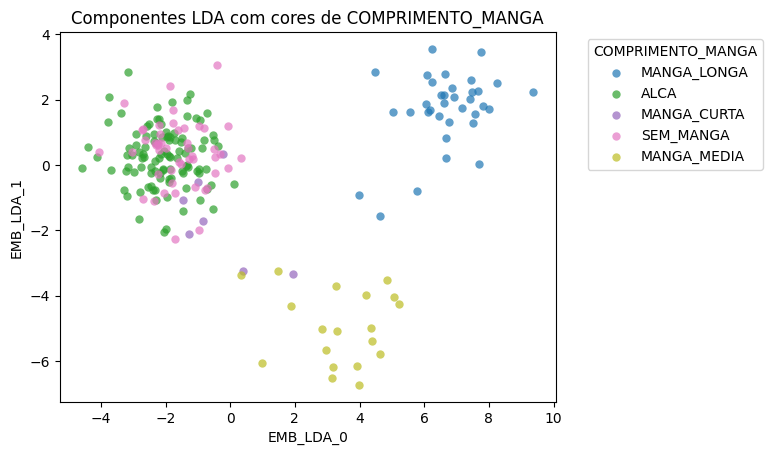

In [118]:
plot_cores(df_lda_comprimento_manga, cor_column='COMPRIMENTO_MANGA', reducer='LDA')

In [134]:
# Obtendo clusters
colunas_lda = [col for col in df_lda_comprimento_manga.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_comprimento_manga
df_combined_comprimento_manga = calcular_centroides(df_lda_comprimento_manga, colunas_lda, 'COMPRIMENTO_MANGA')

# Gerar o gráfico com UMAP
fig = plot_clusters_with_centroids(
    df_combined=df_combined_comprimento_manga,
    target_column='COMPRIMENTO_MANGA',
    embedding_columns=colunas_lda,
    color_dict=None,  # Opcional, pode ser None
    title="Visualização de Clusters com Centróides (LDA + UMAP)",
    apply_umap=True,  # Aplicar UMAP
)

# Mostrar o gráfico
fig.show()

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



### MODELAGEM_SAIA

In [120]:
df_vestido['MODELAGEM_SAIA'].value_counts()

SOLTA    130
JUSTA     63
RETA      22
Name: MODELAGEM_SAIA, dtype: int64

In [122]:
# Aplicando LDA 
df_lda_modelagem_saia, lda_modelagem_saia = apply_lda(df_vestido, emb_columns, n_components=2, colum_target='MODELAGEM_SAIA')

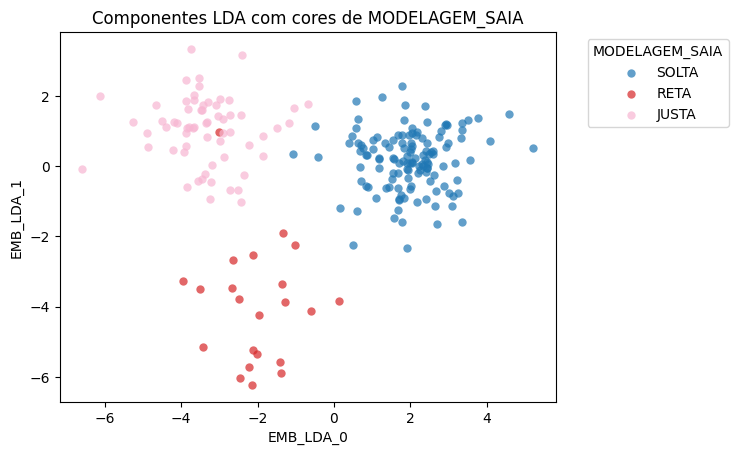

In [124]:
plot_cores(df_lda_modelagem_saia, cor_column='MODELAGEM_SAIA', reducer='LDA')

In [125]:
# Obtendo clusters
colunas_lda = [col for col in df_lda_modelagem_saia.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_modelagem_saia
df_combined_modeladf_lda_modelagem_saia = calcular_centroides(df_lda_modelagem_saia, colunas_lda, 'MODELAGEM_SAIA')

# Gerar o gráfico com UMAP
fig = plot_clusters_with_centroids(
    df_combined=df_combined_modeladf_lda_modelagem_saia,
    target_column='MODELAGEM_SAIA',
    embedding_columns=colunas_lda,
    color_dict=None,  # Opcional, pode ser None
    title="Visualização de Clusters com Centróides (LDA + UMAP)",
    apply_umap=False,  # Aplicar UMAP
)

# Mostrar o gráfico
fig.show()

### DECOTE_OU_GOLA

In [126]:
df_vestido['DECOTE_OU_GOLA'].value_counts()

V                  74
FRENTE_UNICA       30
RETO               29
REDONDO            22
UM_OMBRO_SO        15
CORACAO            14
TOMARA_QUE_CAIA    14
OMBRO_A_OMBRO       9
GOLA_ALTA           3
N/A                 2
DEGAGE              2
GOLA_POLO           1
Name: DECOTE_OU_GOLA, dtype: int64

In [127]:
# Aplicando LDA 
df_lda_decote_ou_gola, lda_decote_ou_gola = apply_lda(df_vestido, emb_columns, n_components=9, colum_target='DECOTE_OU_GOLA')

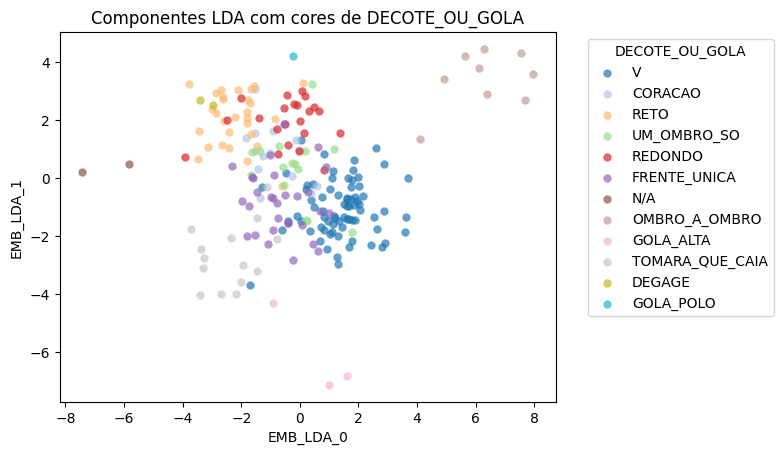

In [128]:
plot_cores(df_lda_decote_ou_gola, cor_column='DECOTE_OU_GOLA', reducer='LDA')

In [144]:
# Obtendo clusters
colunas_lda = [col for col in df_lda_decote_ou_gola.columns if col.startswith('EMB_LDA')]

# Calcular os centróides de df_lda_decote_ou_gola
df_combined_modeladf_lda_decote_ou_gola = calcular_centroides(df_lda_decote_ou_gola, colunas_lda, 'DECOTE_OU_GOLA')

# Gerar o gráfico com UMAP
fig = plot_clusters_with_centroids(
    df_combined=df_combined_modeladf_lda_decote_ou_gola,
    target_column='DECOTE_OU_GOLA',
    embedding_columns=colunas_lda,
    color_dict=None,  # Opcional, pode ser None
    title="Visualização de Clusters com Centróides (LDA + UMAP)",
    apply_umap=True,  # Aplicar UMAP
)

# Mostrar o gráfico
fig.show()

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



### FENDA_PERNA

In [147]:
df_vestido['FENDA_PERNA'].value_counts()

N/A    142
SIM     73
Name: FENDA_PERNA, dtype: int64

In [148]:
# Aplicando LDA
df_lda_fenda_perna, lda_fenda_perna = apply_lda(df_vestido, emb_columns, n_components=1, colum_target='FENDA_PERNA')

In [150]:
df_lda_fenda_perna

,id_produto,FENDA_PERNA,EMB_LDA_0
0,07-16-0077-09657,SIM,2.593214
1,07-20-6541-09621,SIM,0.886823
2,07-20-6630-09258,SIM,1.488207
3,07-20-6705-03344,SIM,4.557301
4,07-20-6347-09538,N/A,-0.772272
...,...,...,...
211,07-20-6778-0005,SIM,3.932166
212,07-20-6402-09248,N/A,-0.439293
213,07-20-6401-0005,N/A,0.060913
214,07-20-6659-09538,N/A,-1.408403


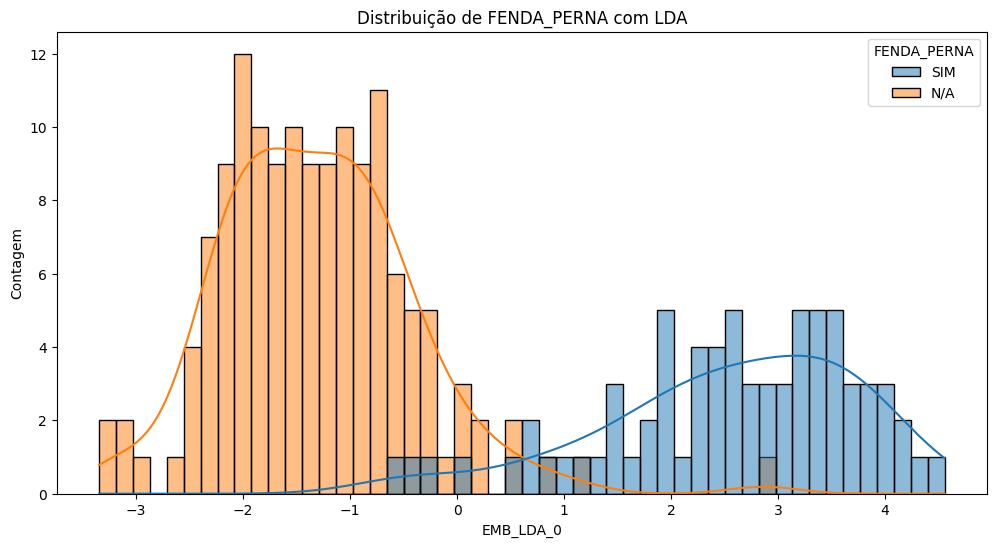

In [159]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_lda_fenda_perna,
    x='EMB_LDA_0',
    hue='FENDA_PERNA',
    kde=True,  # Para adicionar uma curva de densidade
    bins=50  # Número de bins
)
    
# Adicionar rótulos e título
plt.title('Distribuição de FENDA_PERNA com LDA')
plt.xlabel('EMB_LDA_0')
plt.ylabel('Contagem')
plt.show()

In [162]:
df_lda_fenda_perna

,id_produto,FENDA_PERNA,EMB_LDA_0
0,07-16-0077-09657,SIM,2.593214
1,07-20-6541-09621,SIM,0.886823
2,07-20-6630-09258,SIM,1.488207
3,07-20-6705-03344,SIM,4.557301
4,07-20-6347-09538,N/A,-0.772272
...,...,...,...
211,07-20-6778-0005,SIM,3.932166
212,07-20-6402-09248,N/A,-0.439293
213,07-20-6401-0005,N/A,0.060913
214,07-20-6659-09538,N/A,-1.408403


### AMARRACAO_PESCOCO

In [169]:
df_vestido['AMARRACAO_CORPO'].value_counts()

N/A    135
SIM     80
Name: AMARRACAO_CORPO, dtype: int64

In [170]:
# Aplicando LDA
df_lda_amarracao_corpo, lda_amarracao_corpo = apply_lda(df_vestido, emb_columns, n_components=1, colum_target='AMARRACAO_CORPO')

df_lda_amarracao_corpo

,id_produto,AMARRACAO_CORPO,EMB_LDA_0
0,07-16-0077-09657,SIM,2.172638
1,07-20-6541-09621,N/A,-1.611359
2,07-20-6630-09258,N/A,0.255716
3,07-20-6705-03344,N/A,-2.912201
4,07-20-6347-09538,N/A,-1.188830
...,...,...,...
211,07-20-6778-0005,N/A,-0.766306
212,07-20-6402-09248,N/A,-1.667765
213,07-20-6401-0005,N/A,-0.489377
214,07-20-6659-09538,SIM,1.677186


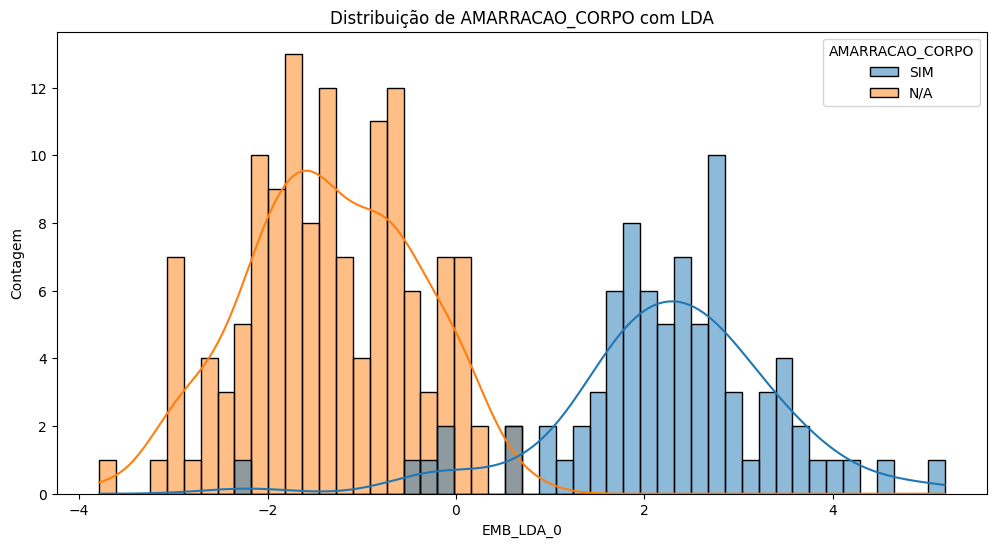

In [171]:
# Plotando em 1 dimensão
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_lda_amarracao_corpo,
    x='EMB_LDA_0',
    hue='AMARRACAO_CORPO',
    kde=True,  # Para adicionar uma curva de densidade
    bins=50  # Número de bins
)

# Adicionar rótulos e título
plt.title('Distribuição de AMARRACAO_CORPO com LDA')

plt.xlabel('EMB_LDA_0')
plt.ylabel('Contagem')

plt.show()

### AMARRACAO_PESCOCO

In [172]:
df_vestido['AMARRACAO_PESCOCO'].value_counts()

N/A    200
SIM     15
Name: AMARRACAO_PESCOCO, dtype: int64

In [173]:
# Aplicando LDA
df_lda_amarracao_pescoco, lda_amarracao_pescoco = apply_lda(df_vestido, emb_columns, n_components=1, colum_target='AMARRACAO_PESCOCO')

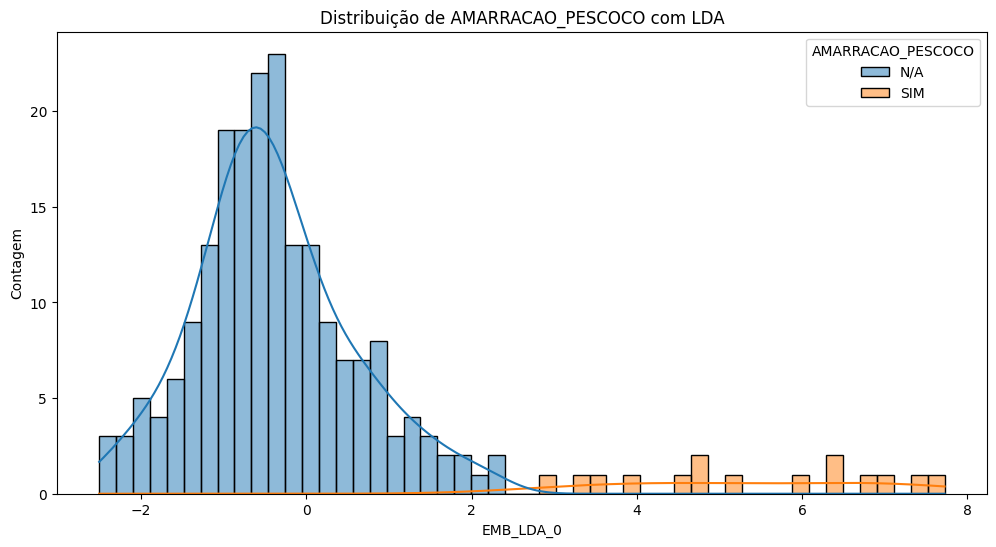

In [174]:
# Plotando em 1 dimensão
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_lda_amarracao_pescoco,
    x='EMB_LDA_0',
    hue='AMARRACAO_PESCOCO',
    kde=True,  # Para adicionar uma curva de densidade
    bins=50  # Número de bins
)

# Adicionar rótulos e título
plt.title('Distribuição de AMARRACAO_PESCOCO com LDA')

plt.xlabel('EMB_LDA_0')
plt.ylabel('Contagem')

plt.show()